<a href="https://colab.research.google.com/github/Jane0731/Homework/blob/main/114_%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90_VAE_0918.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# 設定環境變數解決 OpenMP 警告
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [3]:
# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')

使用裝置: cuda


In [4]:
# 超參數設定
batch_size = 128
learning_rate = 1e-3
epochs = 10
latent_dim = 20  # 潛在空間維度

In [5]:
# 資料預處理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 正規化到[-1, 1]
])

In [6]:
# 載入 MNIST 資料集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


In [7]:
# VAE 模型定義
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )

        # 潛在空間的均值和對數方差
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Tanh()  # 輸出範圍 [-1, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
# 損失函數
def vae_loss(recon_x, x, mu, logvar):
    # 重建損失 (Binary Cross Entropy)
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')

    # KL 散度
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

In [9]:
# 初始化模型
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# 訓練函數
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'訓練 Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t損失: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} 平均損失: {train_loss / len(train_loader.dataset):.4f}')
    return train_loss / len(train_loader.dataset)


In [11]:
# 測試函數
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> 測試集損失: {test_loss:.4f}')
    return test_loss

In [12]:
# 開始訓練
train_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test()
    train_losses.append(train_loss)

訓練 Epoch: 1 [0/60000 (0%)]	損失: 731.330383
訓練 Epoch: 1 [12800/60000 (21%)]	損失: 190.459473
訓練 Epoch: 1 [25600/60000 (43%)]	損失: 138.843994
訓練 Epoch: 1 [38400/60000 (64%)]	損失: 116.589844
訓練 Epoch: 1 [51200/60000 (85%)]	損失: 108.724304
====> Epoch: 1 平均損失: 149.8552
====> 測試集損失: 102.4682
訓練 Epoch: 2 [0/60000 (0%)]	損失: 109.094902
訓練 Epoch: 2 [12800/60000 (21%)]	損失: 98.230888
訓練 Epoch: 2 [25600/60000 (43%)]	損失: 94.401840
訓練 Epoch: 2 [38400/60000 (64%)]	損失: 91.072197
訓練 Epoch: 2 [51200/60000 (85%)]	損失: 92.497208
====> Epoch: 2 平均損失: 93.1446
====> 測試集損失: 85.0999
訓練 Epoch: 3 [0/60000 (0%)]	損失: 91.106064
訓練 Epoch: 3 [12800/60000 (21%)]	損失: 82.030029
訓練 Epoch: 3 [25600/60000 (43%)]	損失: 86.136383
訓練 Epoch: 3 [38400/60000 (64%)]	損失: 85.753387
訓練 Epoch: 3 [51200/60000 (85%)]	損失: 82.201813
====> Epoch: 3 平均損失: 82.5839
====> 測試集損失: 78.6147
訓練 Epoch: 4 [0/60000 (0%)]	損失: 76.495651
訓練 Epoch: 4 [12800/60000 (21%)]	損失: 79.774796
訓練 Epoch: 4 [25600/60000 (43%)]	損失: 74.176651
訓練 Epoch: 4 [38400/60000 (64%)]	損失

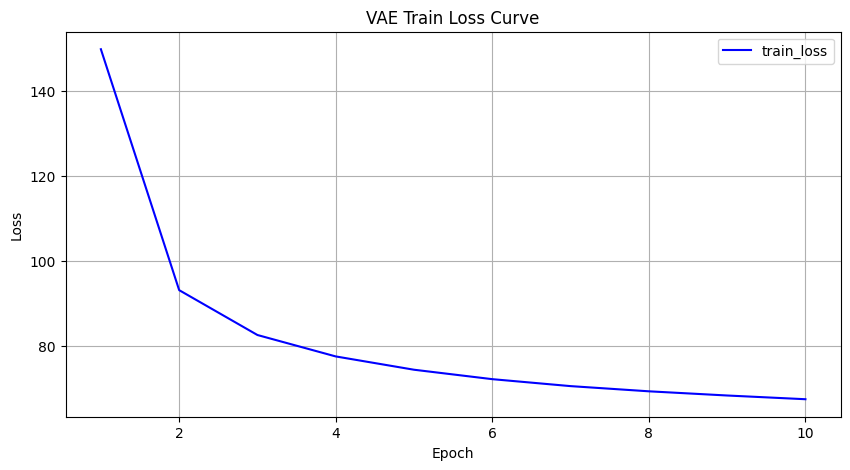

In [21]:
# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, 'b-', label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Train Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 視覺化重建結果
def visualize_reconstruction(num_samples=8):
    model.eval()
    with torch.no_grad():
        # 取得一些測試樣本
        data, _ = next(iter(test_loader))
        data = data[:num_samples].to(device)

        # 重建圖像
        recon_batch, _, _ = model(data)

        # 準備顯示
        data = data.cpu()
        recon_batch = recon_batch.view(-1, 1, 28, 28).cpu()

        # 創建子圖
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

        for i in range(num_samples):
            # 原始圖像
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].set_title('原始')
            axes[0, i].axis('off')

            # 重建圖像
            axes[1, i].imshow(recon_batch[i].squeeze(), cmap='gray')
            axes[1, i].set_title('重建')
            axes[1, i].axis('off')

        plt.suptitle('MNIST 手寫數字重建結果', fontsize=16)
        plt.tight_layout()
        plt.show()

In [15]:
# 生成新的樣本
def generate_samples(num_samples=8):
    model.eval()
    with torch.no_grad():
        # 從標準常態分布中採樣
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28).cpu()

        # 顯示生成的樣本
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].squeeze(), cmap='gray')
            axes[i].set_title(f'生成 {i+1}')
            axes[i].axis('off')

        plt.suptitle('VAE 生成的新樣本', fontsize=16)
        plt.tight_layout()
        plt.show()


顯示重建結果...


/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 23531 (\N{CJK UNIFIED IDEOGRAPH-5BEB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3910100223.py:31: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missi

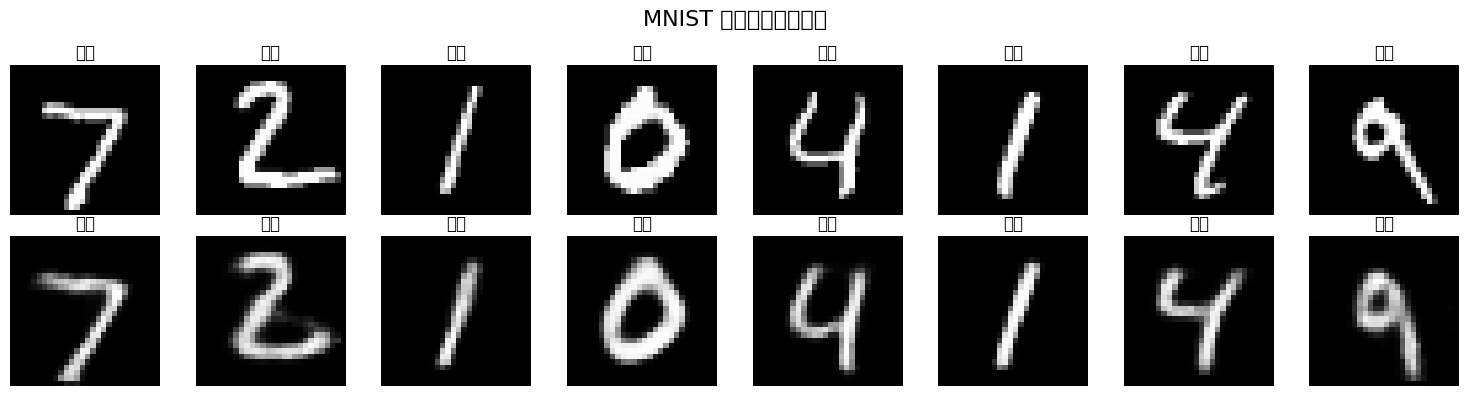

/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


顯示生成樣本...


/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4170905885.py:17: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

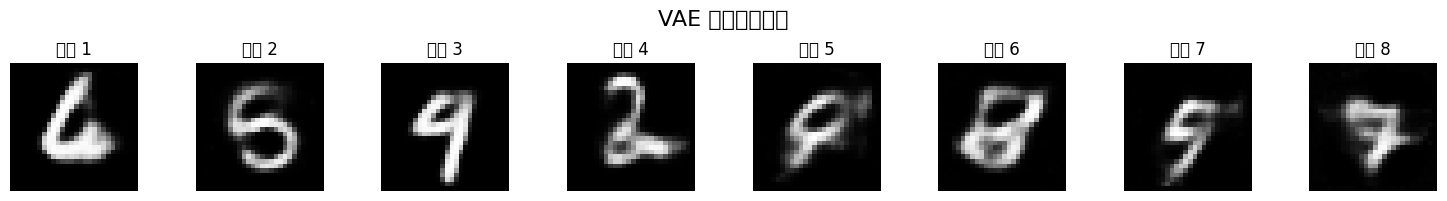

In [16]:
# 顯示結果
print("顯示重建結果...")
visualize_reconstruction()

print("顯示生成樣本...")
generate_samples()

In [17]:
# 儲存模型
torch.save(model.state_dict(), 'vae_mnist_model.pth')
print("模型已儲存為 'vae_mnist_model.pth'")

模型已儲存為 'vae_mnist_model.pth'


In [18]:
print("訓練完成！")

訓練完成！
